## Calculator code

In [1]:
import sys
sys.executable


'/Users/vlachaki/Desktop/Ironhack_projects/Week_7/ml_group_project/dustin/.venv/bin/python'

In [2]:
!which python


/opt/anaconda3/bin/python


In [3]:
import sys
sys.version


'3.11.14 (main, Oct  9 2025, 16:16:55) [Clang 16.0.0 (clang-1600.0.26.6)]'

In [5]:
import numpy as np
import tensorflow as tf
import sklearn

np.__version__, tf.__version__, sklearn.__version__

('1.26.4', '2.12.0', '1.8.0')

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# 1. Load Data
df = pd.read_csv('../data/raw/obesity.csv')

# 2. Feature Engineering: Add BMI
# BMI is a powerful predictor for this specific classification task
df['BMI'] = df['Weight'] / (df['Height'] ** 2)

# 3. Data Treatment: Encoding
# Separate features and target
X = df.drop(['NObeyesdad'], axis=1)
y = df['NObeyesdad']

# Treat Categorical Data: One-Hot Encoding for multi-category features
# This automatically handles Gender, family history, etc.
X = pd.get_dummies(X, drop_first=True)

# Treat Target: Label Encoding
target_le = LabelEncoder()
y = target_le.fit_transform(y)
num_classes = len(target_le.classes_)

# 4. Split and Scale
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# 5. Build the Treated Model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# 6. Optimized Training
model.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

print("Starting treatment-optimized training...")
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=150, 
                    batch_size=32, 
                    callbacks=[early_stop])

Starting treatment-optimized training...
Epoch 1/150
53/53 [==============================] - 1s 5ms/step - loss: 2.0593 - accuracy: 0.2287 - val_loss: 1.7116 - val_accuracy: 0.4563
Epoch 2/150
53/53 [==============================] - 0s 2ms/step - loss: 1.4636 - accuracy: 0.4627 - val_loss: 1.4516 - val_accuracy: 0.5272
Epoch 3/150
53/53 [==============================] - 0s 2ms/step - loss: 1.2401 - accuracy: 0.5504 - val_loss: 1.2005 - val_accuracy: 0.6005
Epoch 4/150
53/53 [==============================] - 0s 2ms/step - loss: 1.0499 - accuracy: 0.6137 - val_loss: 0.9896 - val_accuracy: 0.6619
Epoch 5/150
53/53 [==============================] - 0s 2ms/step - loss: 0.9165 - accuracy: 0.6688 - val_loss: 0.8260 - val_accuracy: 0.7281
Epoch 6/150
53/53 [==============================] - 0s 2ms/step - loss: 0.8188 - accuracy: 0.6949 - val_loss: 0.7109 - val_accuracy: 0.7518
Epoch 7/150
53/53 [==============================] - 0s 2ms/step - loss: 0.7778 - accuracy: 0.7050 - val_loss: 0.

14/14 [==============================] - 0s 2ms/step

==================== CLASSIFICATION REPORT ====================
                     precision    recall  f1-score   support

Insufficient_Weight       0.95      0.96      0.96        56
      Normal_Weight       0.89      0.77      0.83        62
     Obesity_Type_I       0.97      0.97      0.97        78
    Obesity_Type_II       0.97      0.98      0.97        58
   Obesity_Type_III       1.00      1.00      1.00        63
 Overweight_Level_I       0.77      0.88      0.82        56
Overweight_Level_II       0.92      0.88      0.90        50

           accuracy                           0.92       423
          macro avg       0.92      0.92      0.92       423
       weighted avg       0.93      0.92      0.92       423



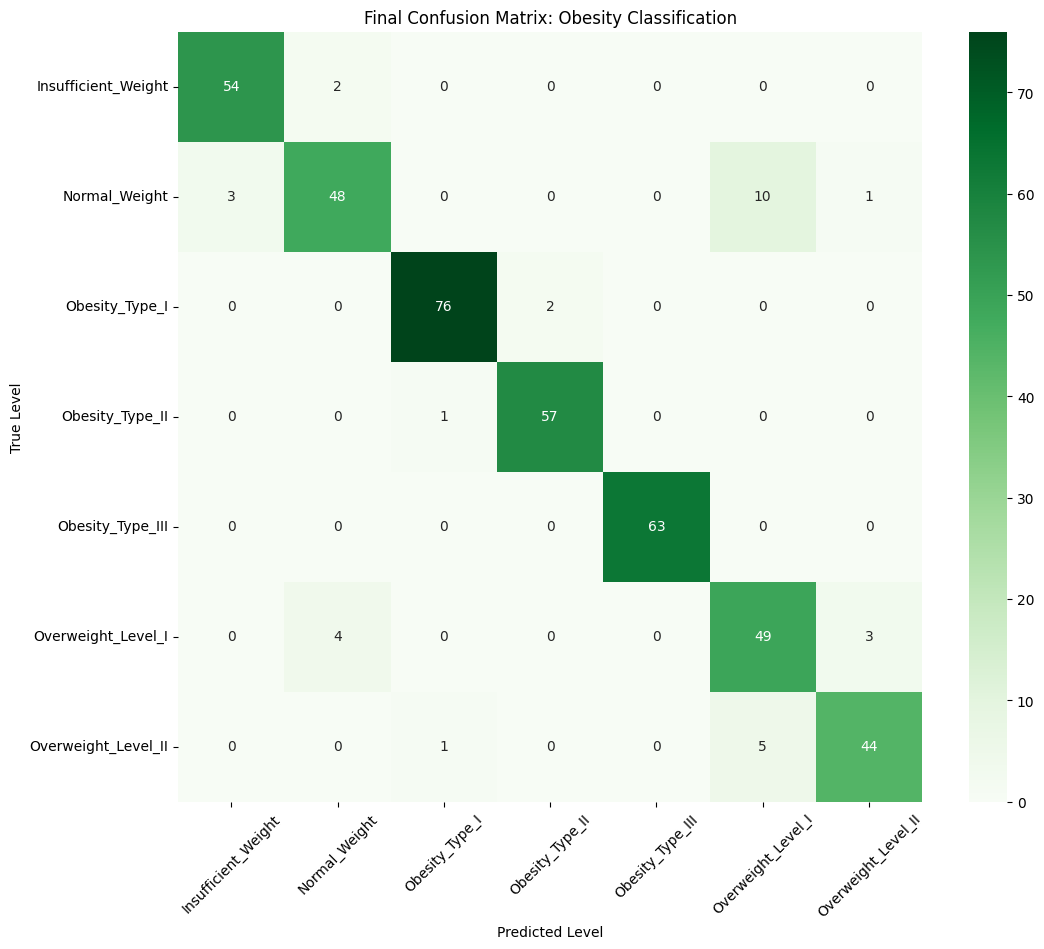

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 1. Predict on the validation set
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)

# 2. Classification Report (The text-based validation)
print("\n" + "="*20 + " CLASSIFICATION REPORT " + "="*20)
print(classification_report(y_val, y_pred, target_names=target_le.classes_))

# 3. Confusion Matrix (The visual validation)
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=target_le.classes_, 
            yticklabels=target_le.classes_)

plt.title('Final Confusion Matrix: Obesity Classification')
plt.ylabel('True Level')
plt.xlabel('Predicted Level')
plt.xticks(rotation=45)
plt.show()

In [8]:
def calculate_obesity_risk(age, gender, snacks, water, exercise):
    """
    age: int
    gender: 'Male' or 'Female'
    snacks: 'no', 'Sometimes', 'Frequently', 'Always'
    water: 1, 2, or 3 (liters)
    exercise: 0, 1, 2, or 3 (days per week)
    """
    
    # 1. Create the data template (matching our One-Hot Encoded columns)
    # We use 'Average' values for height/weight to see the habit-based risk
    test_data = {
        'Age': [age],
        'Height': [1.70], # Baseline
        'Weight': [75],   # Baseline 
        'FCVC': [2],      # Average veggies
        'NCP': [3],       # Average meals
        'CH2O': [water],
        'FAF': [exercise],
        'TUE': [1],       # Average tech use
        'family_history_with_overweight': ['yes'], # Assume history for caution
        'FAVC': ['yes'],
        'CAEC': [snacks],
        'SMOKE': ['no'],
        'SCC': ['no'],
        'CALC': ['Sometimes'],
        'MTRANS': ['Public_Transportation']
    }
    
    # Add engineered BMI
    test_data['BMI'] = [test_data['Weight'][0] / (test_data['Height'][0] ** 2)]
    
    # 2. Convert to DataFrame and align with Training Columns
    input_df = pd.DataFrame(test_data)
    input_df = pd.get_dummies(input_df)
    
    # Ensure this DataFrame has all columns the model was trained on (fill missing with 0)
    input_df = input_df.reindex(columns=X.columns, fill_value=0)
    
    # 3. Scale and Predict
    input_scaled = scaler.transform(input_df)
    probs = model.predict(input_scaled, verbose=0)[0]
    
    # 4. Calculate Risk Score
    # We sum the probabilities for: Obesity_Type_I, Obesity_Type_II, Obesity_Type_III
    # Indices might vary based on your target_le, so we look them up:
    obesity_indices = [i for i, label in enumerate(target_le.classes_) if 'Obesity' in label]
    total_risk = sum(probs[obesity_indices]) * 100
    
    # 5. Determine Primary Tendency
    top_result = target_le.classes_[np.argmax(probs)]
    
    return total_risk, top_result

# --- TEST IT ---
risk, tendency = calculate_obesity_risk(age=25, gender='Female', snacks='Always', water=1, exercise=0)
print(f"Obesity Risk Score: {risk:.1f}%")
print(f"Current Tendency: {tendency}")

Obesity Risk Score: 4.2%
Current Tendency: Overweight_Level_I


In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load Data
df = pd.read_csv('../data/raw/obesity.csv')

# 2. Feature Engineering (The Precision Booster)
df['BMI'] = df['Weight'] / (df['Height'] ** 2)

# 3. Data Treatment
X = df.drop(['NObeyesdad'], axis=1)
y = df['NObeyesdad']

# One-Hot Encoding for habits/gender
X = pd.get_dummies(X, drop_first=True)

# Encode Target
target_le = LabelEncoder()
y = target_le.fit_transform(y)

# 4. Split and Scale (Crucial for KNN!)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# 5. Run KNN
# We'll start with k=5 (looking at the 5 nearest neighbors)
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

# 6. Evaluate
y_pred = knn.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)

print(f"KNN Accuracy: {accuracy*100:.2f}%")
print("\nClassification Report:\n")
print(classification_report(y_val, y_pred, target_names=target_le.classes_))

KNN Accuracy: 84.63%

Classification Report:

                     precision    recall  f1-score   support

Insufficient_Weight       0.78      0.89      0.83        56
      Normal_Weight       0.65      0.53      0.58        62
     Obesity_Type_I       0.90      0.92      0.91        78
    Obesity_Type_II       1.00      0.97      0.98        58
   Obesity_Type_III       0.98      1.00      0.99        63
 Overweight_Level_I       0.77      0.79      0.78        56
Overweight_Level_II       0.78      0.80      0.79        50

           accuracy                           0.85       423
          macro avg       0.84      0.84      0.84       423
       weighted avg       0.84      0.85      0.84       423



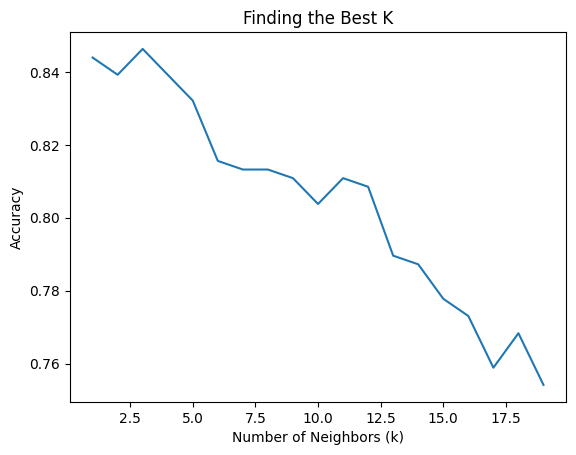

In [10]:
scores = []
for k in range(1, 20):
    knn_test = KNeighborsClassifier(n_neighbors=k)
    knn_test.fit(X_train, y_train)
    scores.append(knn_test.score(X_val, y_val))

plt.plot(range(1, 20), scores)
plt.title('Finding the Best K')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.show()

14/14 [==============================] - 0s 2ms/step


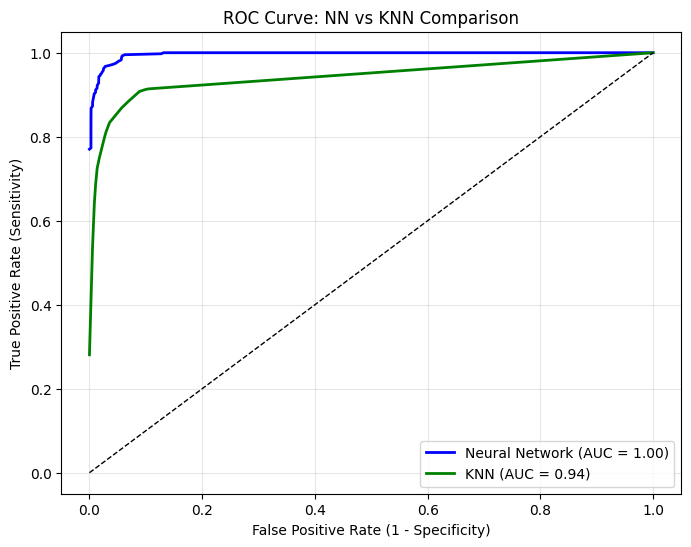

In [11]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# 1. Binarize the labels for multi-class ROC
y_val_bin = label_binarize(y_val, classes=np.unique(y))
n_classes = y_val_bin.shape[1]

# 2. Get Probabilities from both models
# Neural Network probabilities
nn_probs = model.predict(X_val)

# KNN probabilities
knn_probs = knn.predict_proba(X_val)

# 3. Calculate ROC and AUC for each
def get_macro_roc(y_true, y_probs):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    # Interpolate all ROC curves
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    return all_fpr, mean_tpr, auc(all_fpr, mean_tpr)

nn_fpr, nn_tpr, nn_auc = get_macro_roc(y_val_bin, nn_probs)
knn_fpr, knn_tpr, knn_auc = get_macro_roc(y_val_bin, knn_probs)

# 4. Plot the comparison
plt.figure(figsize=(8, 6))
plt.plot(nn_fpr, nn_tpr, label=f'Neural Network (AUC = {nn_auc:.2f})', color='blue', lw=2)
plt.plot(knn_fpr, knn_tpr, label=f'KNN (AUC = {knn_auc:.2f})', color='green', lw=2)
plt.plot([0, 1], [0, 1], 'k--', lw=1) # Random guess line
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve: NN vs KNN Comparison')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

In [12]:
# 1. Get predictions and their probabilities
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)
confidences = np.max(y_pred_probs, axis=1)

# 2. Create a DataFrame for the validation set results
# We need to reverse the scaling to see the original numbers
X_val_original = scaler.inverse_transform(X_val)
outlier_df = pd.DataFrame(X_val_original, columns=X.columns)

# 3. Add the target information
outlier_df['Actual'] = target_le.inverse_transform(y_val)
outlier_df['Predicted'] = target_le.inverse_transform(y_pred)
outlier_df['Confidence'] = confidences

# 4. Filter for errors only
errors = outlier_df[outlier_df['Actual'] != outlier_df['Predicted']].copy()

# 5. Sort by Confidence (The ones the model was SURE about, but got wrong)
top_errors = errors.sort_values(by='Confidence', ascending=False)

print(f"Found {len(errors)} misclassifications.")
print("\nTop 5 Most 'Confusing' Cases:")
print(top_errors[['Actual', 'Predicted', 'Confidence', 'BMI', 'FAF', 'FCVC']].head())

14/14 [==============================] - 0s 2ms/step
Found 32 misclassifications.

Top 5 Most 'Confusing' Cases:
              Actual            Predicted  Confidence        BMI  FAF  FCVC
279    Normal_Weight  Insufficient_Weight    0.973252  18.612245  0.0   3.0
219  Obesity_Type_II       Obesity_Type_I    0.957569  35.185185  0.0   2.0
50     Normal_Weight   Overweight_Level_I    0.924755  24.801587  2.0   2.0
4      Normal_Weight   Overweight_Level_I    0.905410  24.163265  1.0   2.0
292    Normal_Weight   Overweight_Level_I    0.879187  18.938776  2.0   2.0


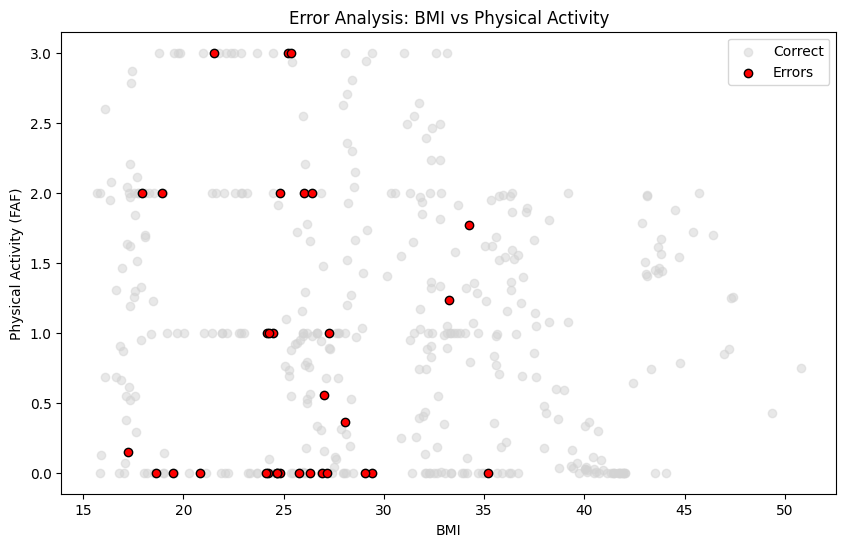

In [13]:
plt.figure(figsize=(10, 6))

# Plot all correct predictions in gray
correct = outlier_df[outlier_df['Actual'] == outlier_df['Predicted']]
plt.scatter(correct['BMI'], correct['FAF'], c='lightgray', alpha=0.5, label='Correct')

# Plot errors in red
plt.scatter(errors['BMI'], errors['FAF'], c='red', edgecolors='black', label='Errors')

plt.title('Error Analysis: BMI vs Physical Activity')
plt.xlabel('BMI')
plt.ylabel('Physical Activity (FAF)')
plt.legend()
plt.show()

Baseline Accuracy: 0.9243
Calculating importance for each feature...


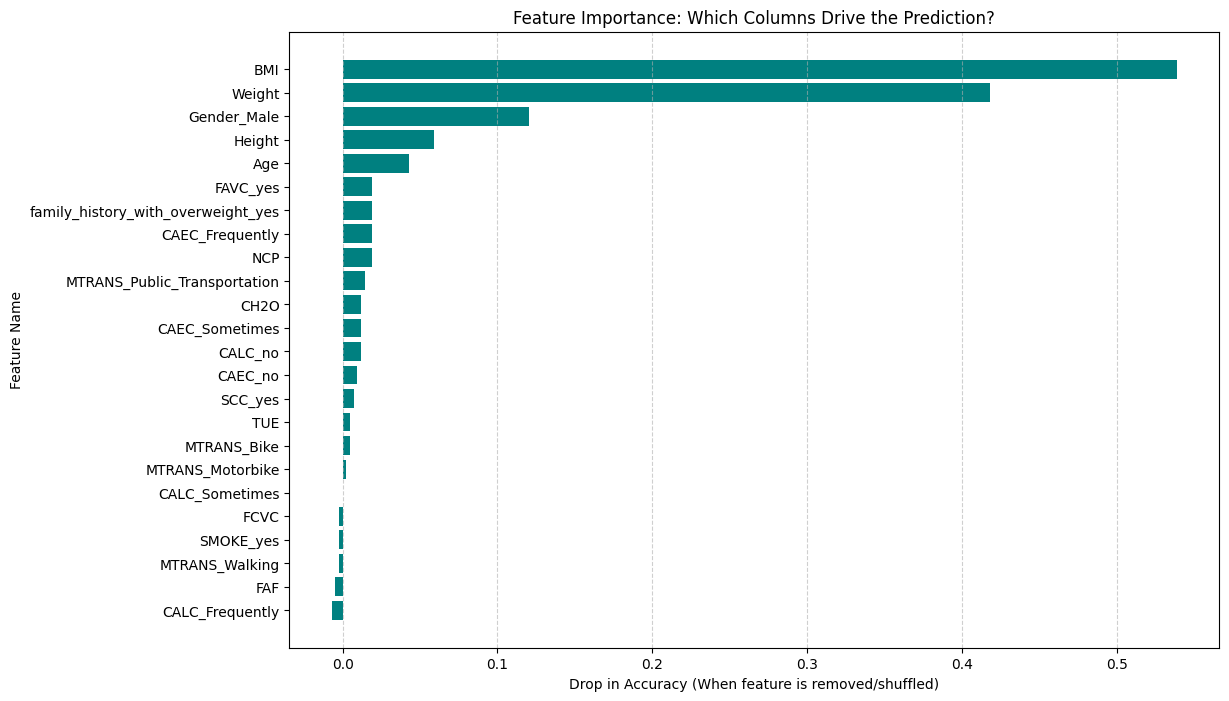


--- Feature Importance Summary ---
                               Feature  Importance_Drop
8                                  BMI         0.539007
2                               Weight         0.418440
9                          Gender_Male         0.120567
1                               Height         0.059102
0                                  Age         0.042553
11                            FAVC_yes         0.018913
10  family_history_with_overweight_yes         0.018913
12                     CAEC_Frequently         0.018913
4                                  NCP         0.018913
22        MTRANS_Public_Transportation         0.014184


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Calculate Baseline Accuracy
# This is how well the model performs normally
y_pred_probs = model.predict(X_val, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)
baseline_accuracy = np.mean(y_pred == y_val)

# 2. Manual Permutation Importance
# We will shuffle each feature and see how much accuracy we lose
feature_importance = {}
feature_names = X.columns # Get original column names

print(f"Baseline Accuracy: {baseline_accuracy:.4f}")
print("Calculating importance for each feature...")

for i, col in enumerate(feature_names):
    # Create a copy of the validation data
    X_val_shuffled = X_val.copy()
    
    # Shuffle only the values in the current column (i)
    np.random.seed(42)
    np.random.shuffle(X_val_shuffled[:, i])
    
    # Predict with the shuffled column
    shuffled_preds = np.argmax(model.predict(X_val_shuffled, verbose=0), axis=1)
    shuffled_accuracy = np.mean(shuffled_preds == y_val)
    
    # Importance = How much accuracy dropped
    # A big drop means the feature is very important!
    drop = baseline_accuracy - shuffled_accuracy
    feature_importance[col] = drop

# 3. Organize and Sort the Results
importance_df = pd.DataFrame({
    'Feature': feature_importance.keys(),
    'Importance_Drop': feature_importance.values()
}).sort_values(by='Importance_Drop', ascending=False)

# 4. Visualize the Report
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance_Drop'], color='teal')
plt.xlabel('Drop in Accuracy (When feature is removed/shuffled)')
plt.ylabel('Feature Name')
plt.title('Feature Importance: Which Columns Drive the Prediction?')
plt.gca().invert_yaxis() # Put the most important at the top
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

# Print the top results
print("\n--- Feature Importance Summary ---")
print(importance_df.head(10))

Average Cross-Validation Score: 84.38%
Best Parameters: {'classifier__max_depth': None, 'classifier__n_estimators': 100}
Final Tuned Accuracy: 69.88%


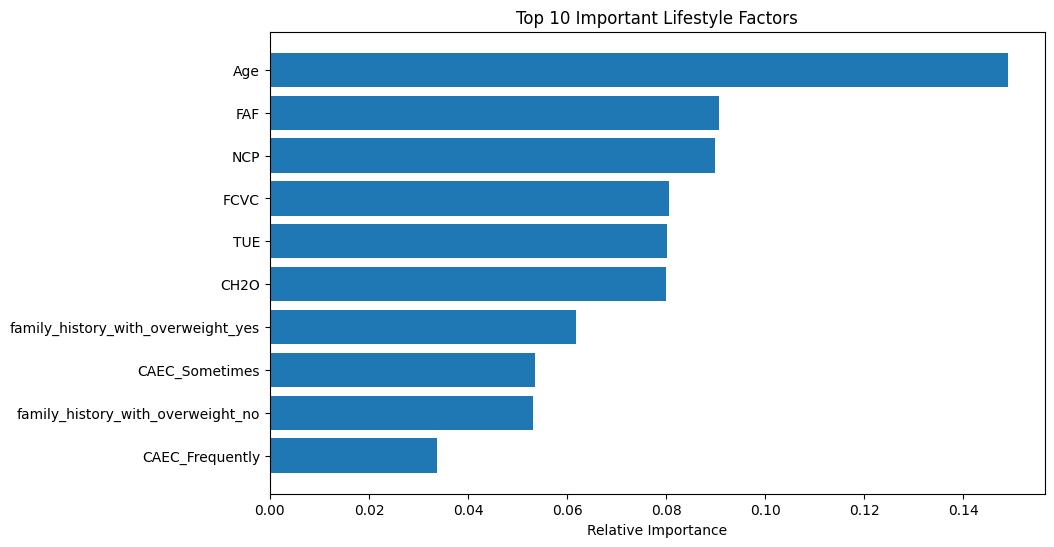

In [15]:
## change of tactics, working on logistic regression

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 1. Load Data with the new path
# This assumes your script is in a folder like 'notebooks/' and the data is in 'data/raw/'
df_lr = pd.read_csv('../data/raw/obesity.csv') 

# 2. Map Target
target_map = {
    'Insufficient_Weight': 0, 'Normal_Weight': 0,
    'Overweight_Level_I': 1, 'Overweight_Level_II': 1,
    'Obesity_Type_I': 2, 'Obesity_Type_II': 2, 'Obesity_Type_III': 2
}
df_lr['Obesity_Group'] = df_lr['NObeyesdad'].map(target_map)

# 3. Define Features (X) and Target (y) - Keeping Height/Weight removed
X = df_lr.drop(['NObeyesdad', 'Obesity_Group', 'Height', 'Weight'], axis=1)
y = df_lr['Obesity_Group']

# 4. Feature Lists
numeric_features = ['Age', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
categorical_features = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']

# 5. Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# 6. Pipeline with Random Forest
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# 7. Cross-Validation (Check stability across the whole dataset)
cv_scores = cross_val_score(rf_pipeline, X, y, cv=5)
print(f"Average Cross-Validation Score: {cv_scores.mean():.2%}")

# 8. Hyperparameter Tuning
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
}

grid_search = GridSearchCV(rf_pipeline, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X, y)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Final Tuned Accuracy: {grid_search.best_score_:.2%}")

# 9. Visualizing Feature Importance
# We extract the feature names after one-hot encoding to see what mattered most
best_model = grid_search.best_estimator_
ohe_feature_names = best_model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numeric_features, ohe_feature_names])

importances = best_model.named_steps['classifier'].feature_importances_
indices = np.argsort(importances)[-10:] # Top 10 features

plt.figure(figsize=(10, 6))
plt.title('Top 10 Important Lifestyle Factors')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [all_feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [16]:
import pandas as pd

def obesity_risk_calculator(model_pipeline):
    print("\n" + "="*40)
    print("      LIFESTYLE RISK CALCULATOR")
    print("="*40)
    print("Please enter your current habits:")
    
    # 1. Collect inputs
    user_data = {
        'Age': float(input("Age: ")),
        'Gender': input("Gender (Male/Female): "),
        'family_history_with_overweight': input("Family history of overweight? (yes/no): "),
        'FAVC': input("Do you eat high caloric food frequently? (yes/no): "),
        'FCVC': float(input("Frequency of vegetable consumption (1-3): ")),
        'NCP': float(input("Number of main meals per day: ")),
        'CAEC': input("Do you eat food between meals? (no/Sometimes/Frequently/Always): "),
        'SMOKE': input("Do you smoke? (yes/no): "),
        'CH2O': float(input("How much water do you drink daily (Liters)? ")),
        'SCC': input("Do you monitor your calories? (yes/no): "),
        'FAF': float(input("Physical activity frequency (0-3): ")),
        'TUE': float(input("Time using technology devices (0-2): ")),
        'CALC': input("How often do you drink alcohol? (no/Sometimes/Frequently/Always): "),
        'MTRANS': input("Primary transportation: ")
    }
    
    # 2. Prepare the data for the model
    input_df = pd.DataFrame([user_data])
    
    # 3. Get the raw probabilities
    # This returns an array like [prob_0, prob_1, prob_2]
    probs = model_pipeline.predict_proba(input_df)[0]
    
    # 4. Display Results
    print("\n" + "-"*40)
    print("         RISK ASSESSMENT")
    print("-"*40)
    print(f"Chance of Normal Weight:    {probs[0]:.2%}")
    print(f"Chance of Overweight:       {probs[1]:.2%}")
    print(f"Chance of Obesity:          {probs[2]:.2%}")
    print("-"*40)

# Run the calculator
obesity_risk_calculator(grid_search.best_estimator_)


      LIFESTYLE RISK CALCULATOR
Please enter your current habits:


Age:  35
Gender (Male/Female):  Male
Family history of overweight? (yes/no):  no
Do you eat high caloric food frequently? (yes/no):  no
Frequency of vegetable consumption (1-3):  2
Number of main meals per day:  3
Do you eat food between meals? (no/Sometimes/Frequently/Always):  Sometimes
Do you smoke? (yes/no):  no
How much water do you drink daily (Liters)?  1
Do you monitor your calories? (yes/no):  yes
Physical activity frequency (0-3):  3
Time using technology devices (0-2):  2
How often do you drink alcohol? (no/Sometimes/Frequently/Always):  Sometimes
Primary transportation:  Walking



----------------------------------------
         RISK ASSESSMENT
----------------------------------------
Chance of Normal Weight:    39.00%
Chance of Overweight:       54.00%
Chance of Obesity:          7.00%
----------------------------------------


## Calculator app

In [17]:
import joblib
joblib.dump(grid_search.best_estimator_, "obesity_risk_model.pkl")


['obesity_risk_model.pkl']

In [21]:
import joblib

joblib.dump(best_model, "risk_model_pipeline.pkl")


['risk_model_pipeline.pkl']

In [22]:
import streamlit as st
import pandas as pd
import joblib

# Load trained model pipeline
model = joblib.load("risk_model_pipeline.pkl")  # adjust filename if needed

st.title("Obesity Risk Calculator")

st.write("Enter lifestyle information to estimate obesity risk.")

# ---- User inputs ----
age = st.number_input("Age", min_value=10, max_value=100, value=30)
gender = st.selectbox("Gender", ["Male", "Female"])
family_history = st.selectbox("Family history of overweight?", ["yes", "no"])
favc = st.selectbox("High-calorie food frequently?", ["yes", "no"])
fcvc = st.slider("Vegetable consumption (1–3)", 1.0, 3.0, 2.0)
ncp = st.slider("Meals per day", 1.0, 4.0, 3.0)
caec = st.selectbox("Snacks between meals", ["no", "Sometimes", "Frequently", "Always"])
smoke = st.selectbox("Do you smoke?", ["yes", "no"])
ch2o = st.slider("Water intake (liters/day)", 1.0, 3.0, 2.0)
scc = st.selectbox("Monitor calories?", ["yes", "no"])
faf = st.slider("Physical activity (days/week)", 0.0, 3.0, 1.0)
tue = st.slider("Screen time (0–2)", 0.0, 2.0, 1.0)
calc = st.selectbox("Alcohol consumption", ["no", "Sometimes", "Frequently", "Always"])
mtrans = st.selectbox("Transportation", [
    "Public_Transportation", "Walking", "Automobile", "Motorbike", "Bike"
])

# ---- Predict ----
if st.button("Calculate Risk"):
    input_df = pd.DataFrame([{
        "Age": age,
        "Gender": gender,
        "family_history_with_overweight": family_history,
        "FAVC": favc,
        "FCVC": fcvc,
        "NCP": ncp,
        "CAEC": caec,
        "SMOKE": smoke,
        "CH2O": ch2o,
        "SCC": scc,
        "FAF": faf,
        "TUE": tue,
        "CALC": calc,
        "MTRANS": mtrans
    }])

    probs = model.predict_proba(input_df)[0]

    st.subheader("Risk Probabilities")
    st.write(f"Low risk: {probs[0]:.1%}")
    st.write(f"Medium risk: {probs[1]:.1%}")
    st.write(f"High risk: {probs[2]:.1%}")


2026-01-15 13:01:57.324 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-15 13:01:57.325 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-15 13:01:57.326 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-15 13:01:57.327 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-15 13:01:57.328 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-15 13:01:57.329 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-15 13:01:57.330 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-15 13:01:57.331 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [ ]:
streamlit run app.py
